# EDA

En este notebook se incluye:

0. Análisis de cardinalidad y clasificación de variables
1. Análisis univariante: Distribución de cada variable individual
2. Análisis bivariante: Relaciones entre pares de variables
3. Análisis multivariante: Patrones complejos entre múltiples variables
4. Generar todos los estadísticos y gráficos necesarios para entender vuestro dataset

Importante: Mientras realizáis el EDA, id construyendo la memoria técnica de forma paralela. Documentad cada análisis, decisión y hallazgo en el momento. Esto facilitará enormemente el trabajo posterior.

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from IPython.display import display

In [89]:
df_drugs = pd.read_csv("../data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("../data/data_clean/drugs_no_na.csv", index_col=0)

**HIPÓTESIS**

🔹 H1. Los hombres consumen más estupefacientes que las mujeres en todos los grupos de edad y en todos los paises

📌 Problema que se aborda: diferencia de la prevalencia de consumo por grupo de edad, por género y por tipo de estupefaciente 
- Análisis que hacemos: cantidad qu consumen hombrees y mujeres, cantidad que consumen por grupo de edad, relaciones entre consumo y genero, relacion entre consumo y grupo de edad, analisis de que tipo de droga consumen mas por genero y que tipo de droga consumen mas por edad
Aquí unimos la hipótesis 1 y la hipótesis 2

🔹 H2. Existen diferencias en la prevalencia del consumo de estupefacientes entre países europeos
📌 Problema que se aborda: analizamos qué droga se consume más en cada país
- Análisis que hacemos: la prevalencia del consumo por país y podemos determinar si hay diferencias o no por países respecto el consumo: en qué países se consume más, que tipo de droga consumen más e incluso podemos añadir información para cada pais de genero, edad y tipo de droga (si son muchos países podemos unificarlo tipo: paises mediterraneos, paises nordicos, paises europa central)

Aquí la junto con la hipótesis 3

🔹 H3. La prevalencia del consumo varía de forma notable según el recall period, siendo mayor en medidas de consumo a lo largo de la vida que en periodos recientes.

📌 Problema: interpretación correcta de indicadores.


Hipótesis que teníamos que elimino:
H2. Los jóvenes de 15-34 años tienen mayor prevalencia de consumo que los grupos poblacionales mayores


H3. El alcohol es la sustancia más consumida en todos los países europeos



# 0. Análisis previo cardinalidad

In [ ]:
# ===================
# Funciones que voy a usar para análisis univariante
# las pongo colapsadas para que no ocupen mucho
# ===================

# Función que calcula la cardinalidad y el tipo de variable
def cardinalidad(df_in, umbral_categoria = 10, umbral_continua = 30):

    resultado = []
    for col in df_in.columns:
        card = df_in[col].nunique()
        porc_card = df_in[col].nunique()/len(df_in) * 100
        tipo = df_in[col].dtypes
        if card == 2:
            clasif = "Binaria"
        elif card < umbral_categoria:
            clasif = "Categórica"
        elif card >= umbral_categoria:
            if porc_card >= umbral_continua:
                clasif = "Numérica Continua"
            else:
                clasif = "Numérica Discreta"

        # Añadimos los resultados a la lista
        resultado.append({
            "columna": col,
            "tipo": tipo,
            "cardinalidad": card,
            "porcentaje_card": porc_card,
            "clasificacion": clasif
        })
    
    # Convertimos la lista de dicts en dataframe
    df_resul = pd.DataFrame(resultado)
        
    return df_resul

# 3. Función que representa las frecuencias absolutas o relativas en gráficos
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def columnas_numericas(df):
    num_col = df.describe().columns.to_list()
    return num_col

# Función para representar boxplots de columnas numéricas
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_histo_dens(df, columns, bins=None):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            if bins:
                sns.histplot(df[column], kde=True, ax=axes[i], bins=bins)
            else:
                sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Función que representa el histograma y el boxplot de varias variables
def plot_combined_graphs(df, columns, whisker_width=1.5):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0])
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

In [ ]:
cardinalidad(df_drugs)

,columna,tipo,cardinalidad,porcentaje_card,clasificacion
0,country,object,29,2.780441,Numérica Discreta
1,survey_year,int64,12,1.150527,Numérica Discreta
2,prevalence_(%),float64,358,34.324065,Numérica Continua
3,substance,object,7,0.671141,Categórica
4,recall_period,object,3,0.287632,Categórica
5,age,object,2,0.191755,Binaria
6,sample_size,float64,76,7.286673,Numérica Discreta
7,males_(%),float64,377,36.145733,Numérica Continua
8,females_(%),float64,333,31.927133,Numérica Continua
9,gender_gap,float64,379,36.337488,Numérica Continua


In [ ]:
df_drugs.nunique()


country            29
survey_year        12
prevalence_(%)    358
substance           7
recall_period       3
age                 2
sample_size        76
males_(%)         377
females_(%)       333
gender_gap        379
dtype: int64

# HIPOTESIS H2 : Existen diferencias en la prevalencia del consumo de estupefacientes entre países europeos, considerando :
# -tipo de sustancia,
# -género,
# -grupo de edad,

## Estructura H2:
### 1.Filtrar el “escenario estándar” (ej. Adults 15–64 + Last year).
### 2.Ranking de países por sustancia (top 10/15).
### 3.Dentro de cada país, ver qué sustancia es la más alta.
### 4.Género: diferencias (Male–Female) por país, sustancia.
### 5.Edad: repetir para “Young adults 15–34” vs “Adults 15–64”.
### 6.Conclusiones: 3–5 bullets claros.







# 1. Análisis univariante

## 1.1. Análisis univariante categóricas

In [ ]:
#Analizamos variables una a una, para entender como es el dataset

In [ ]:
df_drugs.columns = df_drugs.columns.str.lower()

In [ ]:
categorical_cols = [
    "country",    
    "substance",
    "recall_period",
    "age"
]

In [ ]:
#CONTEO DE VALORES
from IPython.display import display
for col in categorical_cols:
    print(f"\n--- {col}---")
    display(df_drugs[col].value_counts(dropna=False))


--- country---


country
Austria        42
Bulgaria       42
Croatia        42
Cyprus         42
Germany        42
Portugal       42
Romania        42
Italy          42
Slovakia       42
Ireland        42
Latvia         41
Czechia        40
Lithuania      40
Hungary        38
Finland        38
Türkiye        38
Poland         36
Estonia        36
Spain          36
Luxembourg     36
Netherlands    34
Slovenia       34
Greece         32
Denmark        30
France         30
Norway         30
Sweden         22
Belgium        20
Malta          12
Name: count, dtype: int64


--- substance---


substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64


--- recall_period---


recall_period
Last year     367
Lifetime      348
Last month    328
Name: count, dtype: int64


--- age---


age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64

In [ ]:
#Nº de países
#Sustancias incluidas(cannabis, cocaina, alcohol,etc.)
#Periodos de recuerdo(Lifetime, Last year, Last month)
#Grupos de edad(Adults 15-64, Young adults 15-34)

In [ ]:
df_drugs.columns.tolist()

['country',
 'survey_year',
 'prevalence_(%)',
 'substance',
 'recall_period',
 'age',
 'sample_size',
 'males_(%)',
 'females_(%)',
 'gender_gap']

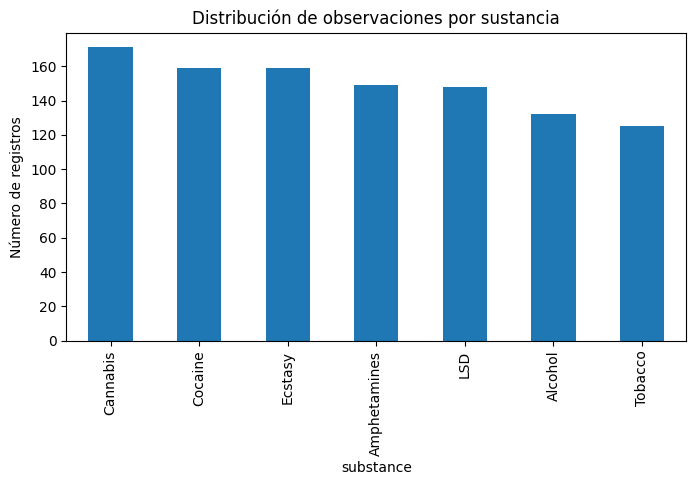

In [ ]:
#Gráficos sustancias
plt.figure(figsize=(8,4))

df_drugs["substance"].value_counts().plot(kind="bar")

plt.title("Distribución de observaciones por sustancia")

plt.ylabel("Número de registros")

plt.show()

## 1.2. Análisis univariante numéricas

In [ ]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1043 non-null   object 
 1   survey_year     1043 non-null   int64  
 2   prevalence_(%)  1043 non-null   float64
 3   substance       1043 non-null   object 
 4   recall_period   1043 non-null   object 
 5   age             1043 non-null   object 
 6   sample_size     950 non-null    float64
 7   males_(%)       1017 non-null   float64
 8   females_(%)     1001 non-null   float64
 9   gender_gap      1001 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 89.6+ KB


In [ ]:
num_cols = columnas_numericas(df_drugs)

In [ ]:
numeric_cols = [
    "prevalence_(%)",
    "males_(%)",
    "females_(%)"
]   

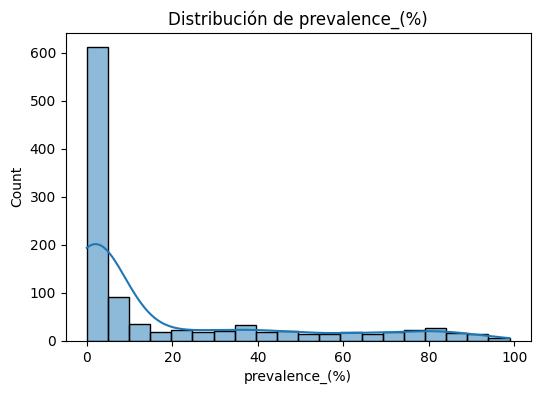

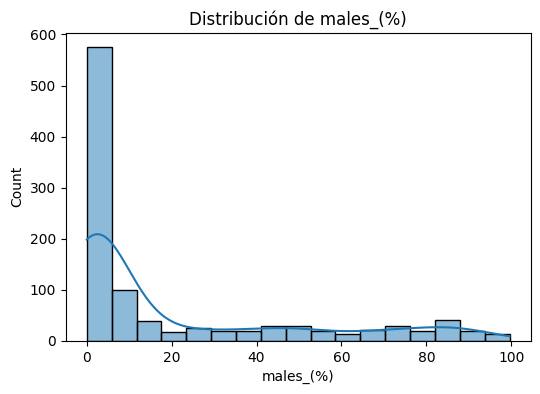

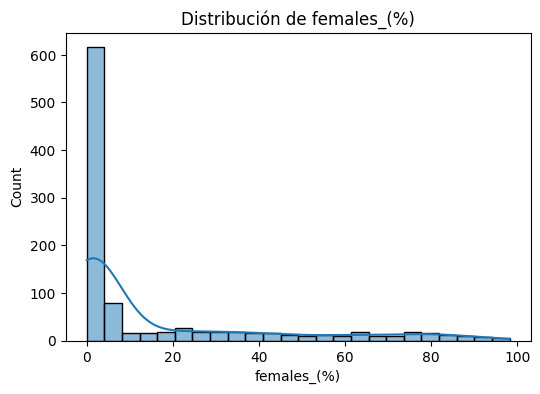

In [ ]:
for col in numeric_cols:

    plt.figure(figsize=(6,4))

    sns.histplot(df_drugs[col], kde=True)

    plt.title(f"Distribución de {col}")

    plt.show()

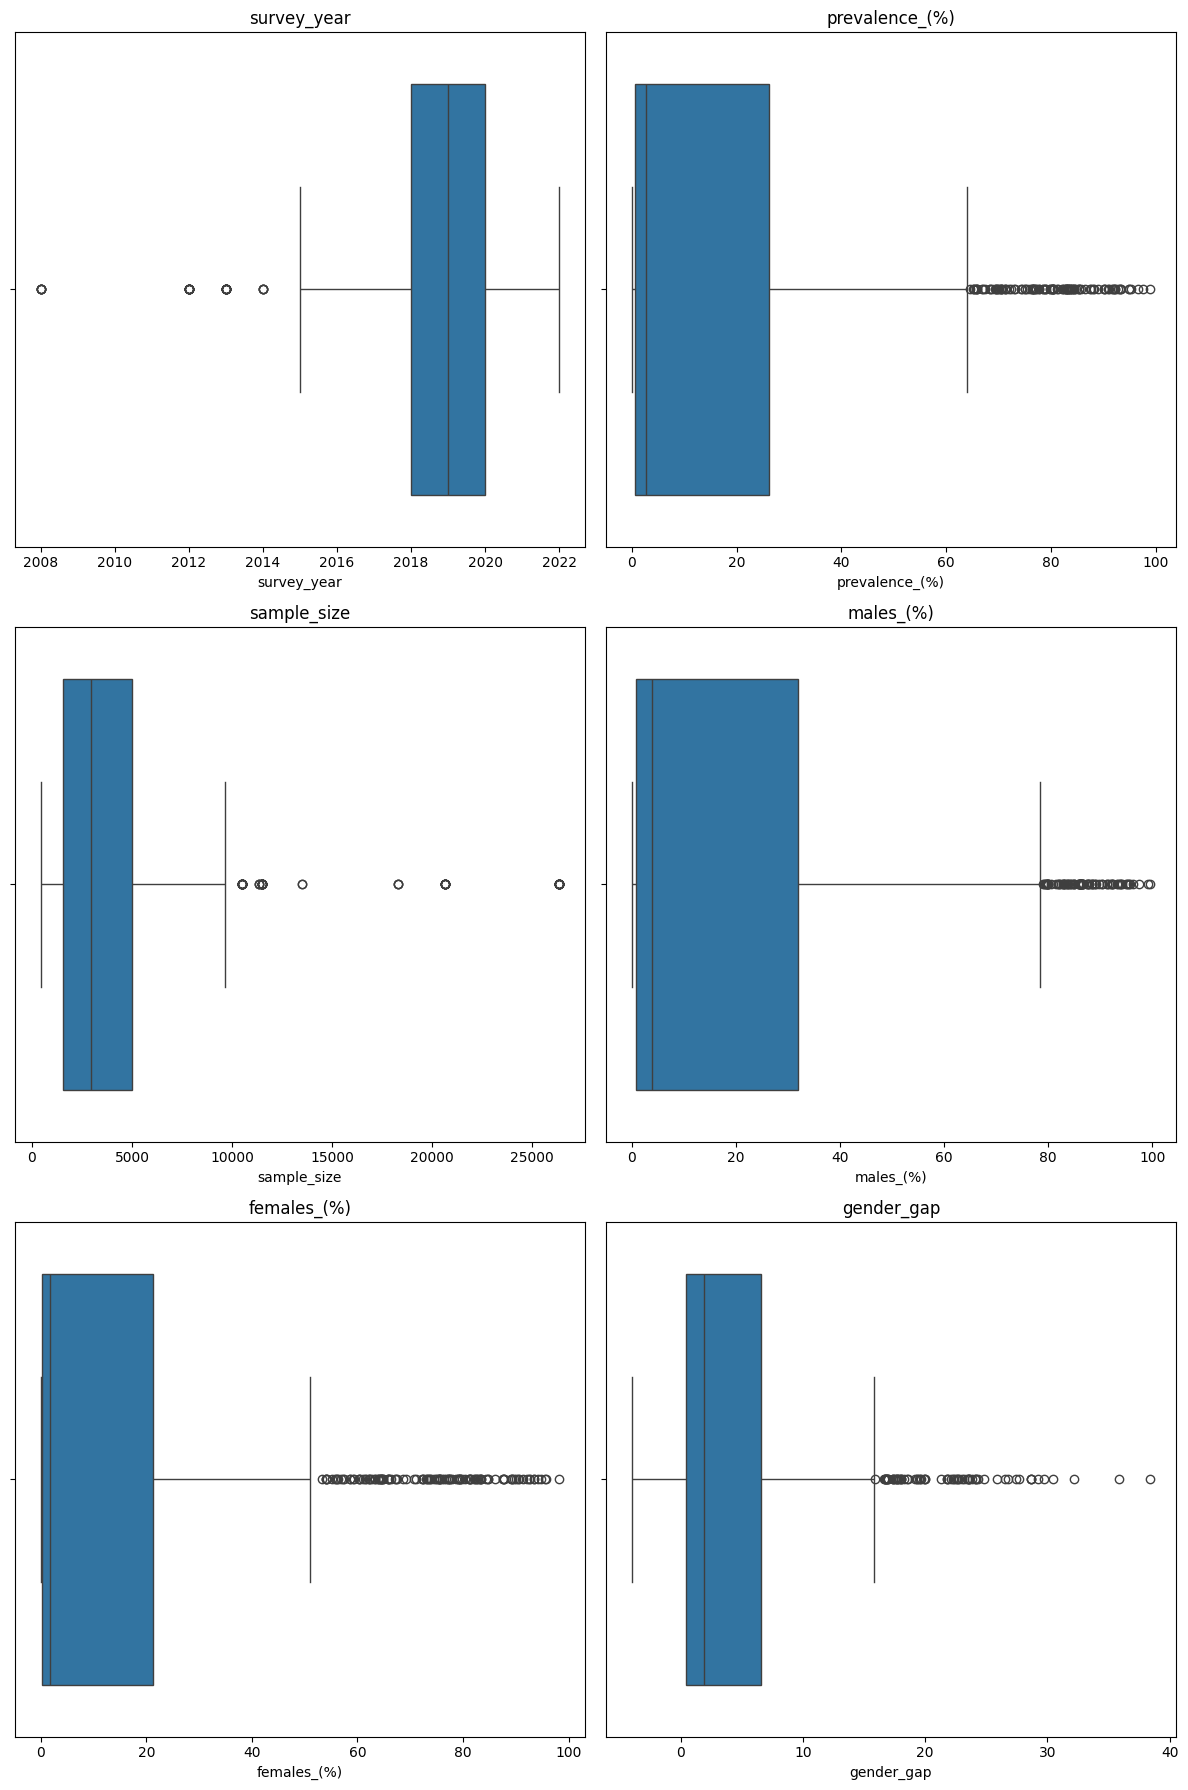

In [ ]:
plot_multiple_boxplots(df_drugs, columns=num_cols)

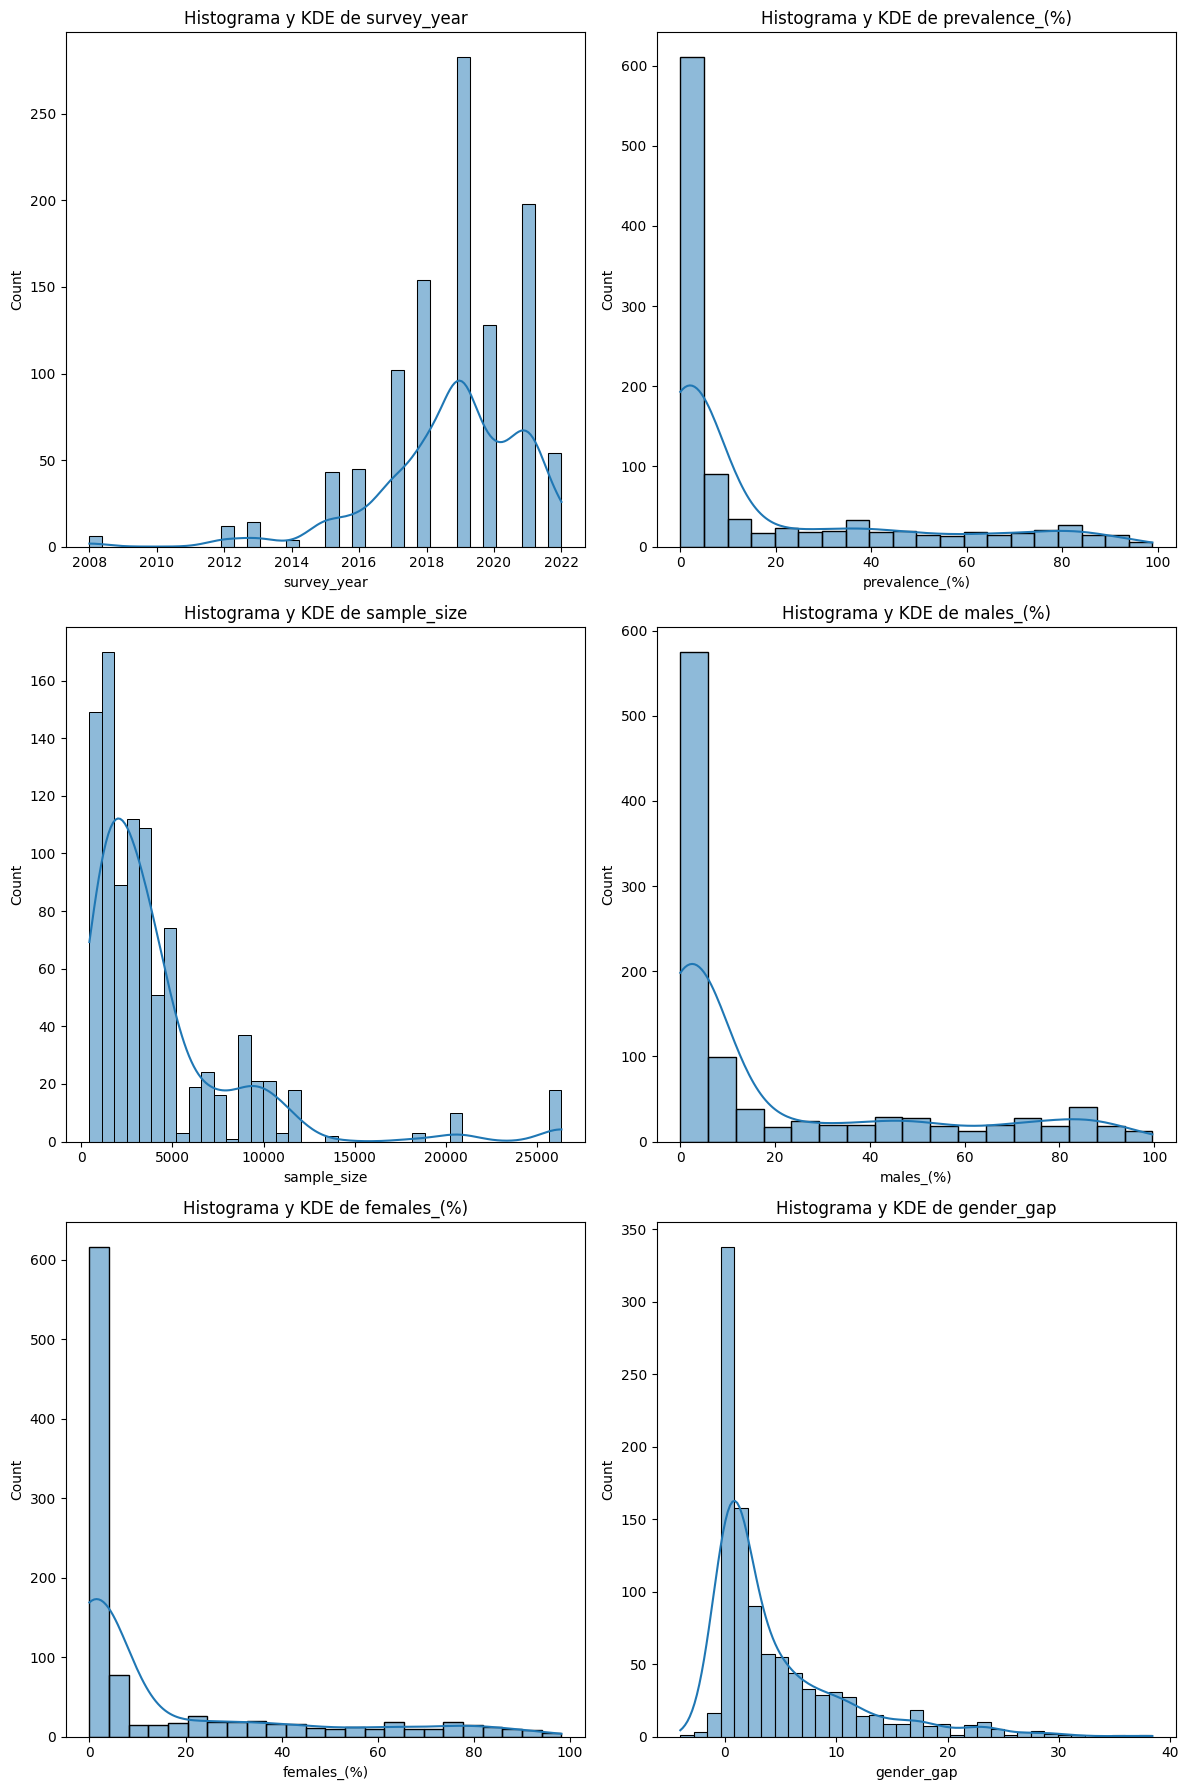

In [ ]:
plot_histo_dens(df_drugs, columns=num_cols)

(6, 2)


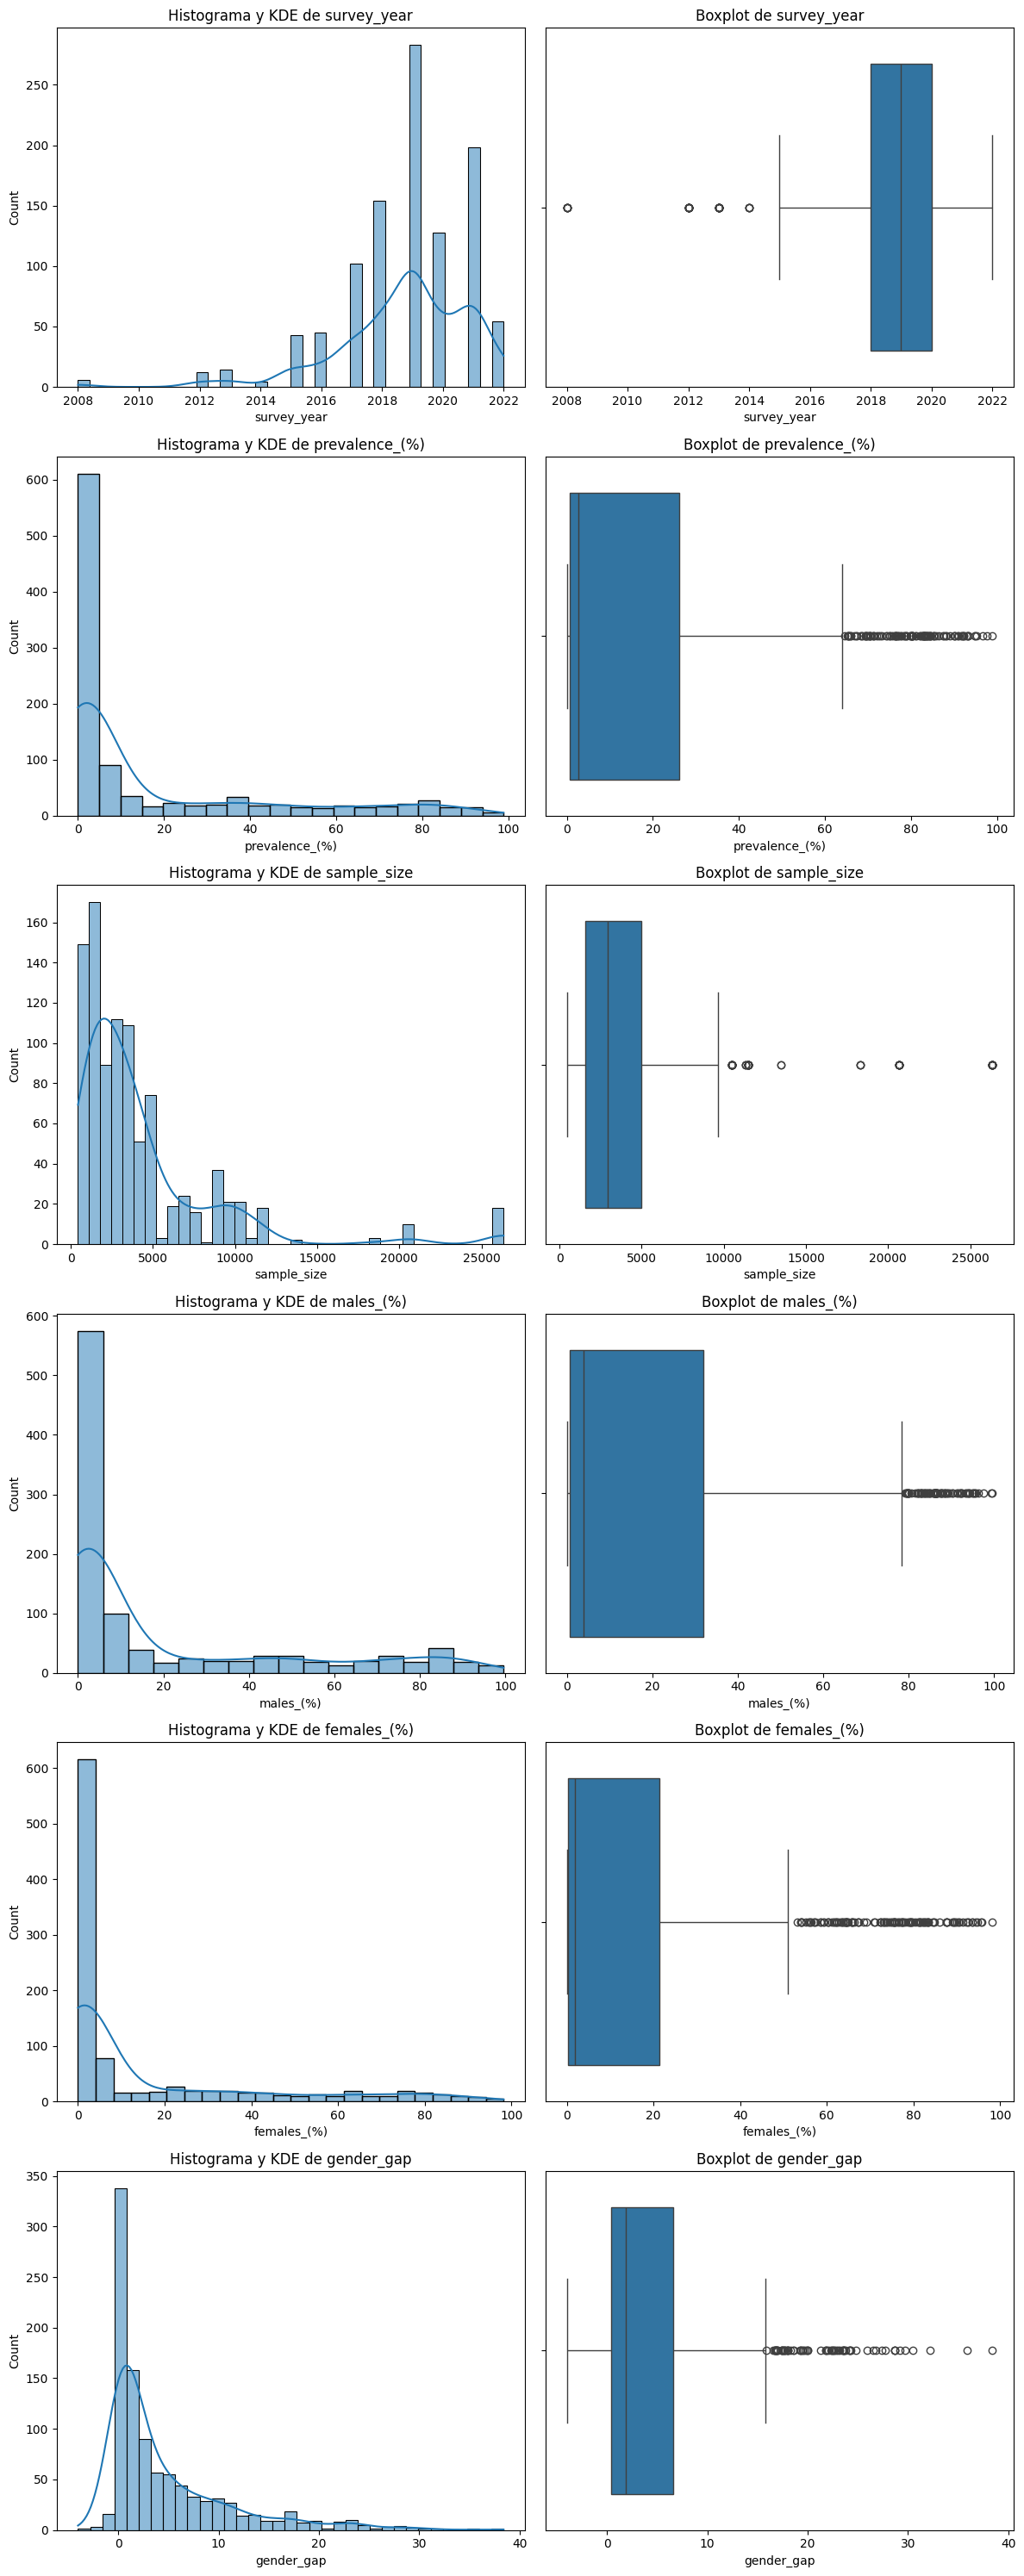

In [ ]:
plot_combined_graphs(df_drugs, columns=num_cols)

# 2. Análisis bivariante

In [ ]:
# ===================
# Funciones que voy a usar para análisis bivariante
# las pongo colapsadas para que no ocupen mucho
# ===================

# Función análisis bivariante categóricas
def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 5):

    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(5, 3))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

def grafico_dispersion_con_correlacion(df, columna_x, columna_y, tamano_puntos=50, mostrar_correlacion=False):
    """
    Crea un diagrama de dispersión entre dos columnas y opcionalmente muestra la correlación.

    Args:
    df (pandas.DataFrame): DataFrame que contiene los datos.
    columna_x (str): Nombre de la columna para el eje X.
    columna_y (str): Nombre de la columna para el eje Y.
    tamano_puntos (int, opcional): Tamaño de los puntos en el gráfico. Por defecto es 50.
    mostrar_correlacion (bool, opcional): Si es True, muestra la correlación en el gráfico. Por defecto es False.
    """

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=columna_x, y=columna_y, s=tamano_puntos)

    if mostrar_correlacion:
        correlacion = df[[columna_x, columna_y]].corr().iloc[0, 1]
        plt.title(f'Diagrama de Dispersión con Correlación: {correlacion:.2f}')
    else:
        plt.title('Diagrama de Dispersión')

    plt.xlabel(columna_x)
    plt.ylabel(columna_y)
    plt.grid(True)
    plt.show()

## 2.1. Análisis bivariante categóricas

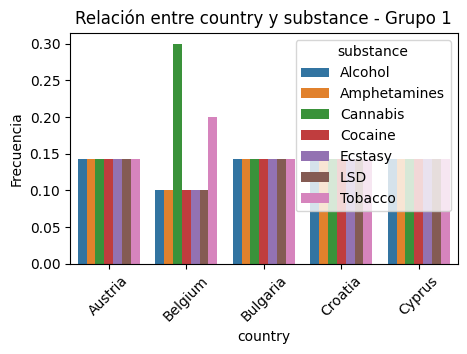

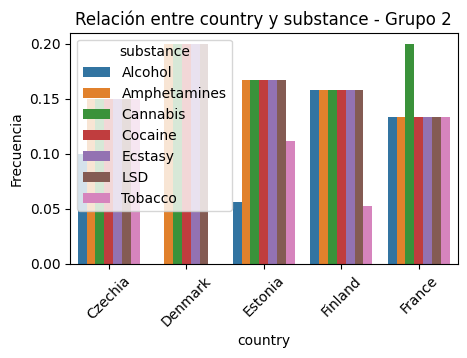

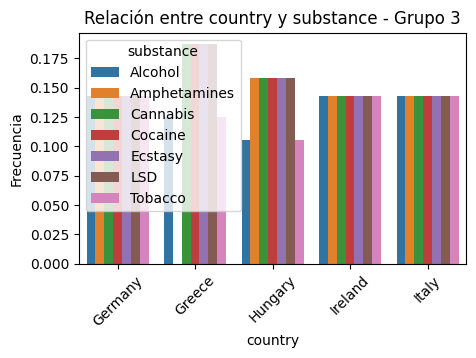

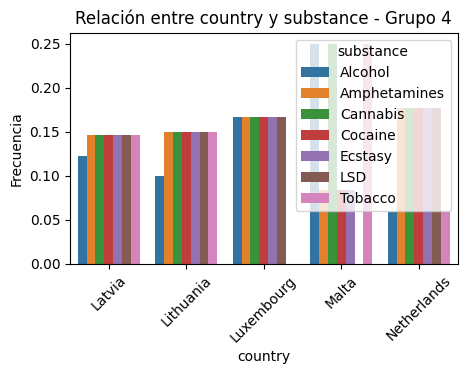

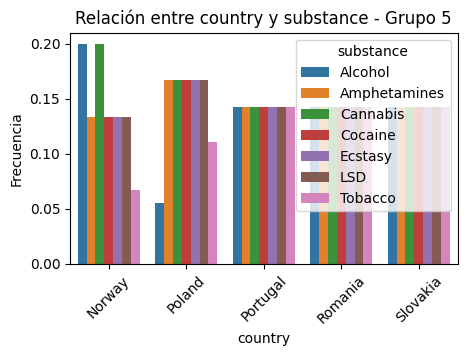

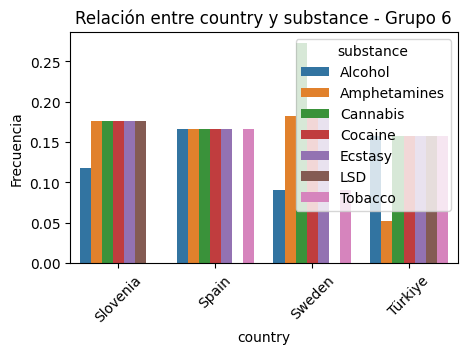

In [ ]:
plot_categorical_relationship_fin(df_drugs, "country", "substance", relative_freq=True, show_values=False, size_group=5)

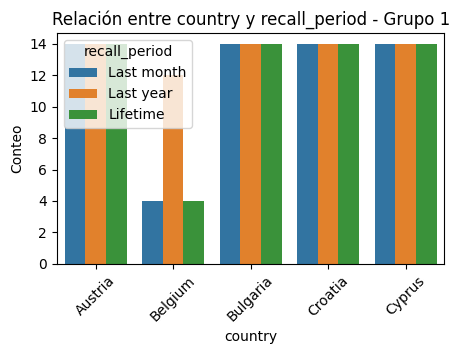

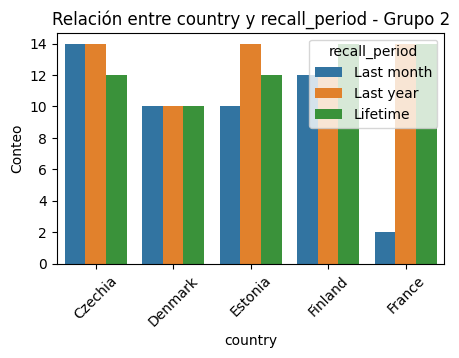

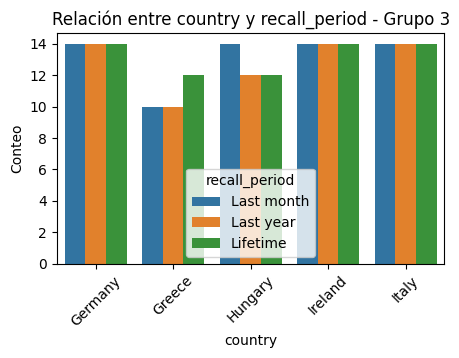

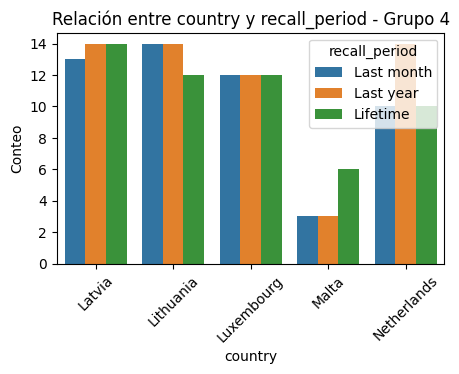

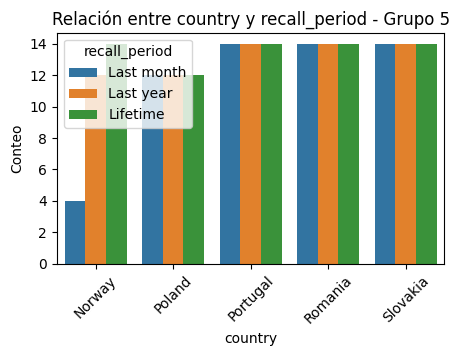

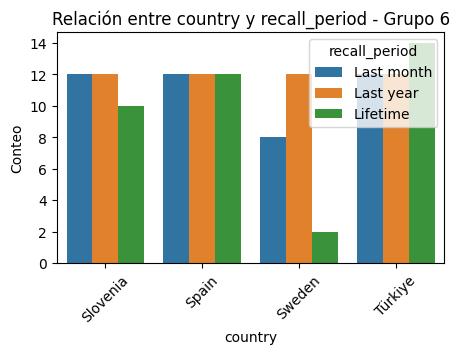

In [109]:
plot_categorical_relationship_fin(df_drugs, "country", "recall_period")

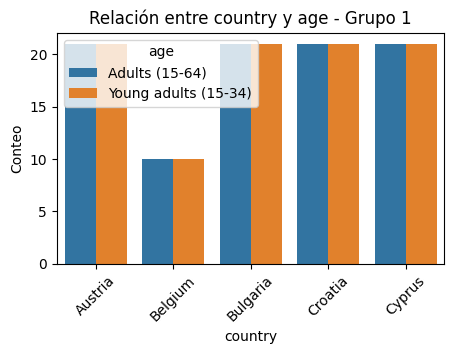

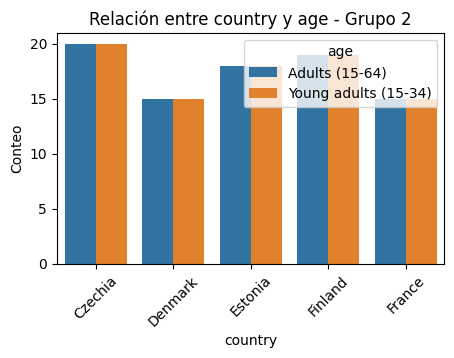

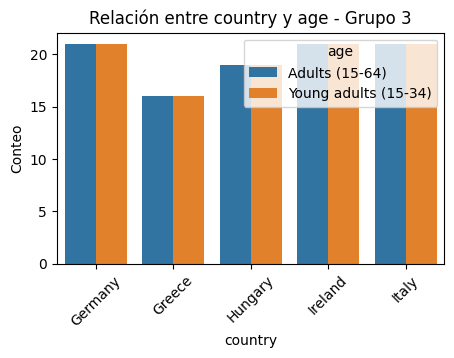

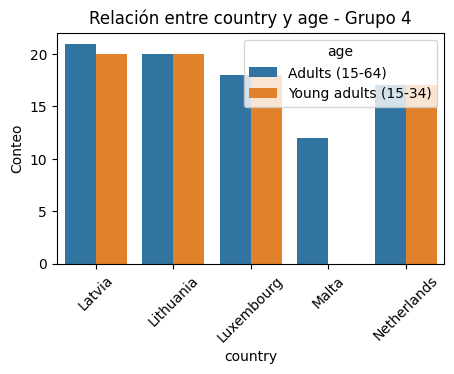

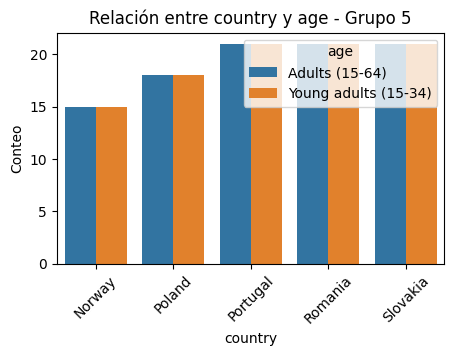

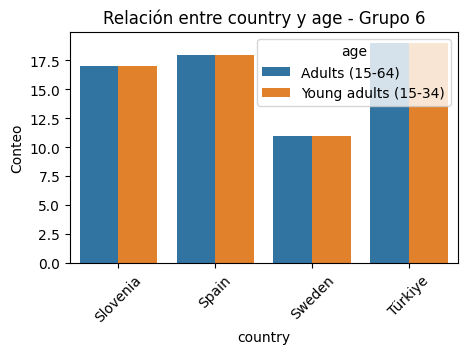

In [110]:
plot_categorical_relationship_fin(df_drugs, "country", "age")

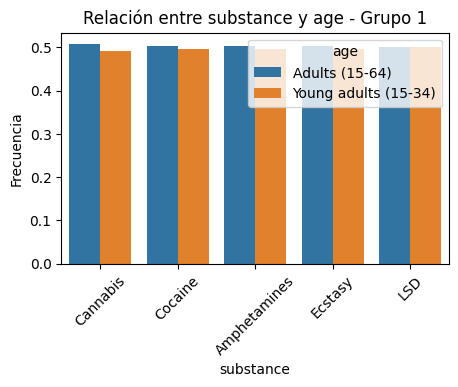

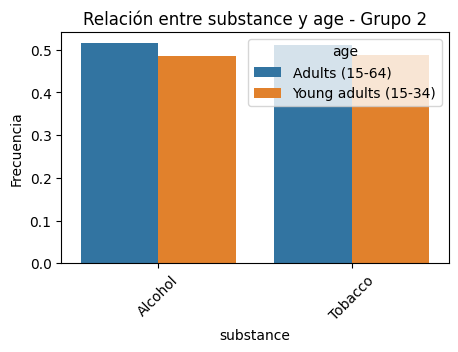

In [111]:
plot_categorical_relationship_fin(df_drugs, "substance", "age", relative_freq=True)

## 2.2. Análisis bivariante numéricas

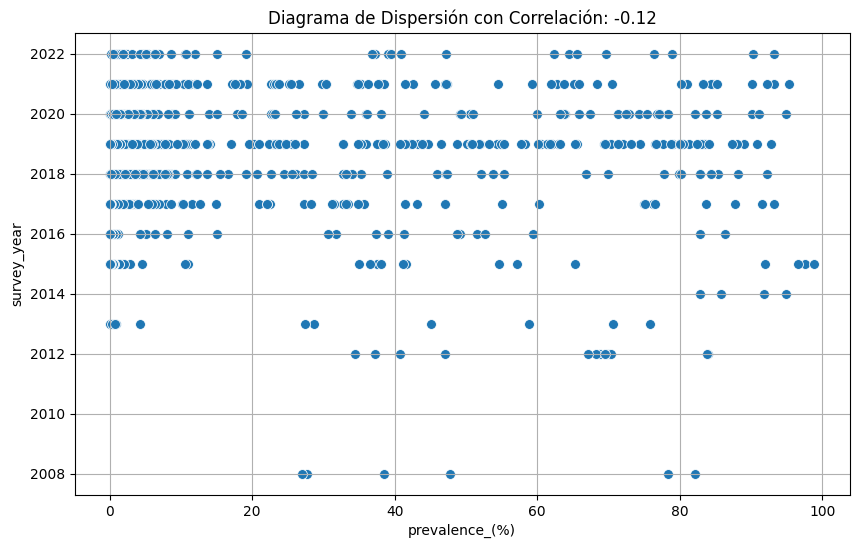

In [112]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "survey_year", mostrar_correlacion=True)

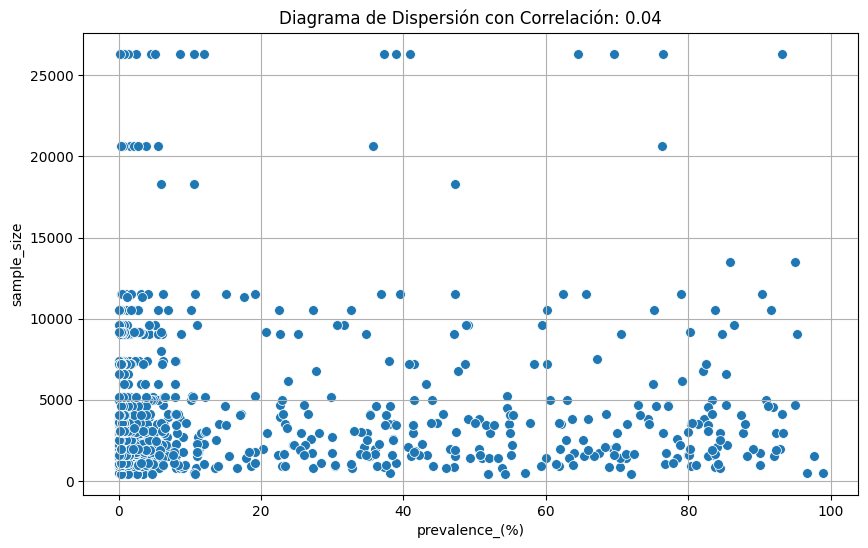

In [113]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "sample_size", mostrar_correlacion=True)

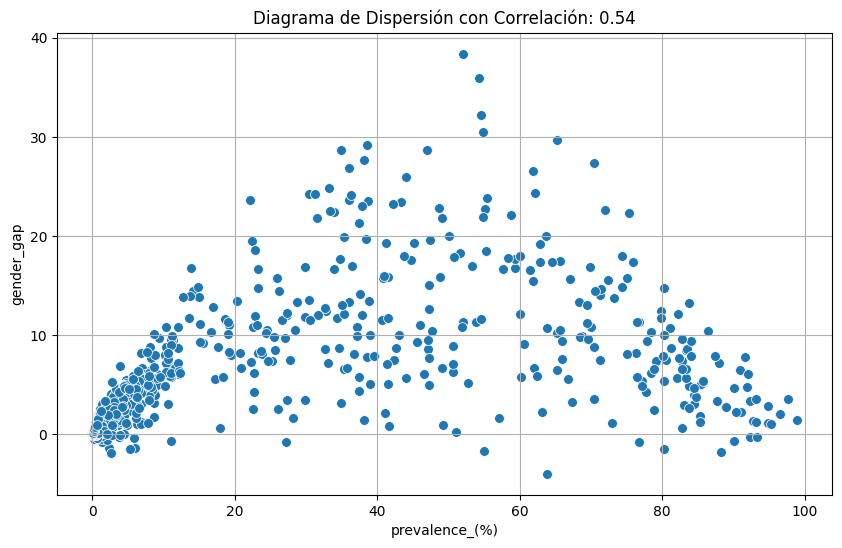

In [114]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "gender_gap", mostrar_correlacion=True)

## 2.3. Análisis bivariante categórica-numérica

In [ ]:
#2.1 Prevalencia por país
#Escenario estándar

df_std = df_drugs[
    (df_drugs["age"] == "Adults (15-64)") &
    (df_drugs["recall_period"] == "Last year")
]
#Todos los países por prevalencia (ej. cannabis)

df_std = df_drugs[
    (df_drugs["age"] == "Adults (15-64)") &
    (df_drugs["recall_period"] == "Last year")
]


In [124]:
#2.2 Diferencias por género
#Creamos una variable útil

df_std["gender_gap"] = df_std["males_(%)"] - df_std["females_(%)"]

C:\Users\api11\AppData\Local\Temp\ipykernel_7424\3662387962.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_std["gender_gap"] = df_std["males_(%)"] - df_std["females_(%)"]


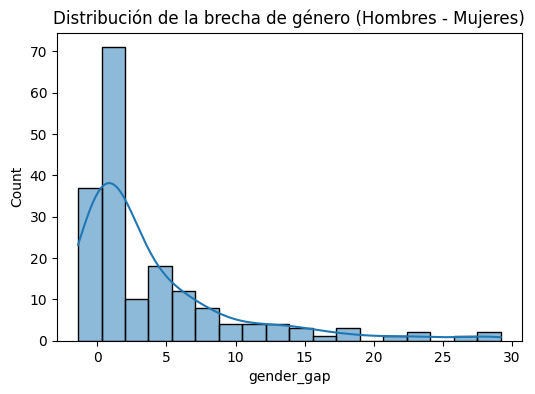

In [118]:
#VISUALIZACIÓN

plt.figure(figsize=(6,4))
sns.histplot(df_std["gender_gap"], kde=True)
plt.title("Distribución de la brecha de género (Hombres - Mujeres)")
plt.show()

(367, 10)


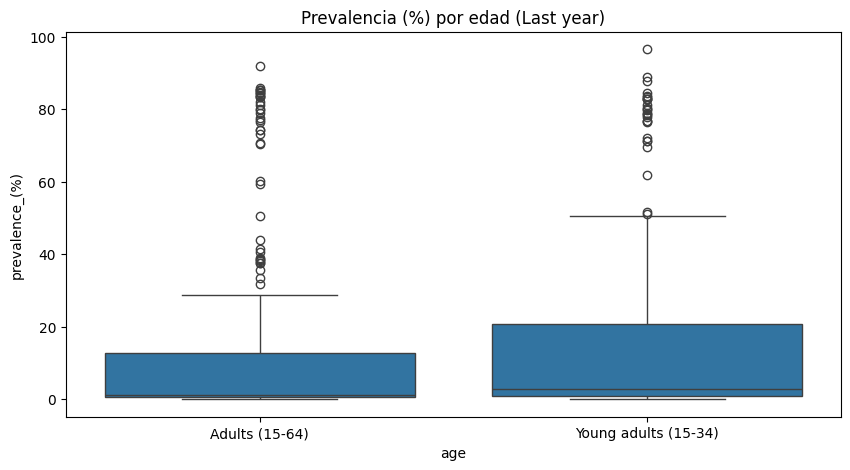

In [ ]:
#Valores positivos consumen más los hombres
#Valores negativos más mujeres poco frecuente.
#2.3 Edad
df_age = df_drugs[df_drugs["recall_period"] == "Last year"].copy()

print(df_age.shape)  # para verificar que ya tiene filas

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_age, x="age", y="prevalence_(%)")
plt.title("Prevalencia (%) por edad (Last year)")
plt.show()

## “Para comparar el consumo por edad he utilizado diagramas de cajas. Se observa que en jóvenes adultos la mediana de prevalencia es mayor y la dispersión más amplia, lo que indica tanto mayor consumo como mayor variabilidad entre países y sustancias. En adultos, en cambio, el consumo es más homogéneo y generalmente menor.”

## En jóvenes adultos el consumo no solo es mayor, sino también más variable, mientras que en adultos los valores son más homogéneos.

# 3. Análisis multivariante

In [ ]:
#Cruzamos país+ sustancia+género 

pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance"
)



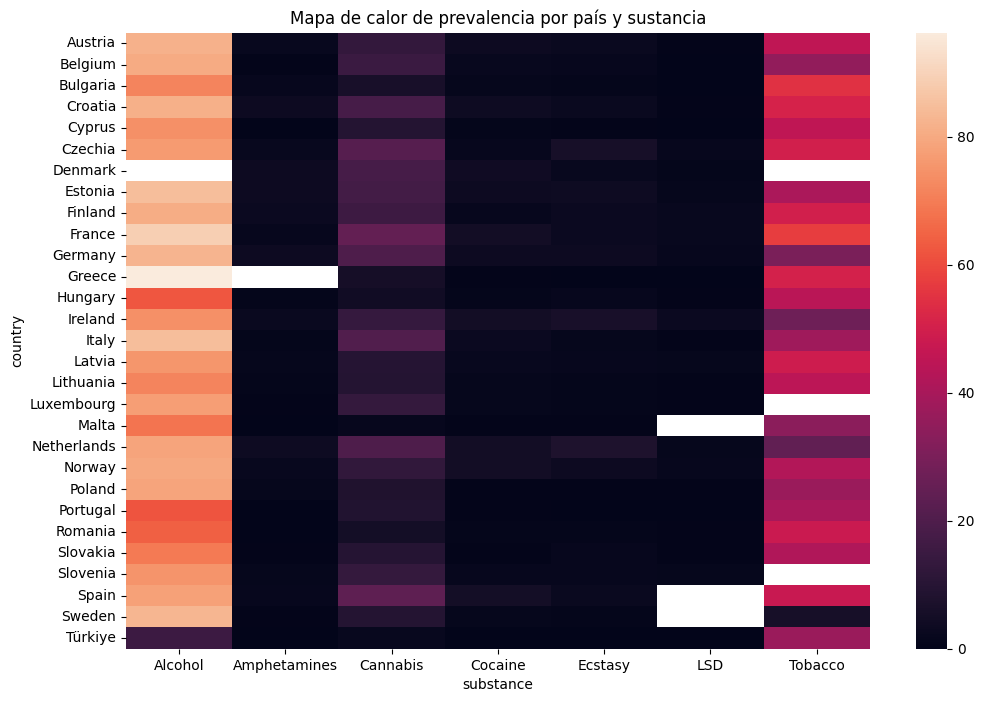

In [ ]:
# 1) Crear pivot
pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance",
    aggfunc="mean"
)

# 2) Pintar heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot)
plt.title("Mapa de calor de prevalencia por país y sustancia")
plt.show()

In [ ]:
df_gender = df_drugs.melt(
    id_vars=["country", "substance", "survey_year", "recall_period", "age"],
    value_vars=["males_(%)", "females_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender["gender"] = df_gender["gender"].str.replace("_(%)", "", regex=False)
df_gender["prevalence"] = pd.to_numeric(df_gender["prevalence"], errors="coerce")

df_gender.head()

pivot_gender = df_gender.pivot_table(
    values="prevalence",
    index="country",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender.head()

substance    Alcohol            Amphetamines             Cannabis             \
gender       females      males      females     males    females      males   
country                                                                        
Austria    81.083333  82.733333     1.633333  2.700000  12.450000  13.416667   
Belgium    77.400000  83.300000     0.200000  1.100000  10.216667  19.316667   
Bulgaria   64.883333  78.766667     1.516667  1.616667   6.316667   6.450000   
Croatia    77.500000  85.166667     1.816667  4.666667  12.550000  22.733333   
Cyprus     66.483333  82.400000     0.033333  0.383333   4.666667  13.866667   

substance   Cocaine             Ecstasy                 LSD            \
gender      females     males   females     males   females     males   
country                                                                 
Austria    2.616667  3.583333  2.133333  2.783333  0.616667  0.666667   
Belgium    0.800000  3.450000  0.800000  2.900000  0.050000  0.000000   
Bulgaria   1.300000  1.450000  1.000000  0.700000  0.166667  0.116667   
Croatia    1.783333  5.033333  1.283333  3.933333  0.516667  1.000000   
Cyprus     0.350000  1.866667  0.266667  1.133333  0.033333  0.650000   

substance    Tobacco             
gender       females      males  
country                          
Austria    44.533333  46.133333  
Belgium    30.925000  39.775000  
Bulgaria   52.950000  56.933333  
Croatia    47.550000  54.150000  
Cyprus     33.383333  57.766667

In [3]:
#2.heatmap2: Brecha de género( hombres-mujeres)

pivot_gap = df_drugs.pivot_table(
    values="gender_gap",
    index="country",
    columns="substance",
    aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_gap, cmap= "BrBG",
            center=0,)
plt.title("Mapa de calor: brecha de género (Hombres − Mujeres)")
plt.xlabel("Sustancia")
plt.ylabel("País")
plt.tight_layout()
plt.show()

NameError: name 'df_drugs' is not defined

In [ ]:
#3 Países con mayor brecha de género
topN = 10
rank_gap = (
    df_drugs.dropna(subset=["gender_gap"])
    .sort_values("gender_gap", ascending=False)
    .groupby("substance")
    .head(topN)
)

rank_gap[["substance", "country", "survey_year", "gender_gap"]]

,substance,country,survey_year,gender_gap
468,Alcohol,Hungary,2019,38.4
469,Alcohol,Hungary,2019,35.9
592,Alcohol,Latvia,2015,32.2
182,Tobacco,Cyprus,2019,30.5
633,Tobacco,Lithuania,2021,29.7
...,...,...,...,...
318,LSD,Finland,2018,3.2
624,LSD,Lithuania,2021,3.1
461,LSD,Hungary,2019,3.0
321,LSD,Finland,2018,2.8


In [ ]:
#4 Comparación por edad( Young adults vs Adults)
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

df_age = (
    df_age.sort_values("survey_year")
    .groupby(["country", "substance", "age"])
    .tail(1)
)

pivot_age = df_age.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns=["age", "substance"],
    aggfunc="mean"
)

## Para la mayoría de sutancias, los jóvenes adultos presentan mayores prevalencias que la población adulta, aunque la magnitud de la diferencia depende de la sustancia.

# CONCLUSIONES



## Existen diferencias claras entre países europeos en la prevalencia del consumo.
## El cannabis y el alcohol presentan mayores prevalencias que otras sustancias.
## En la mayoría de países, la prevalencia es mayor en hombres que en mujeres.
## Los jóvenes adultos presentan patrones distintos según la sustancia analizada.
## El periodo de recuerdo influye notablemente en los valores observados.

## “Observamos diferencias claras en la prevalencia del consumo entre países europeos,que además varían según la sustancia analizada.El mapa de calor muestra patrones geográficos diferenciados, especialmente en cannabis y cocaína.



## Al incorporar el género, vemos que la brecha hombres–mujeres no es homogénea entre países ni sustancias,lo que refuerza la hipótesis de que el consumo no solo depende del país, sino también del perfil sociodemográfico.



## Finalmente, el análisis por edad indica que estas diferencias se acentúan en determinados grupos etarios,especialmente en jóvenes adultos.”

# 4. Estadísticos y gráficos

In [ ]:
#PREPARAMOS LOS DATOS
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

df_age = (
    df_age.sort_values("survey_year")
    .groupby(["country", "substance", "age"])
    .tail(1)
)

In [ ]:
#MEDIA DE PREVALENCIA POR EDAD Y SUSTANCIA
age_stats = (
    df_age
    .groupby(["age", "substance"])["prevalence_(%)"]
    .mean()
    .reset_index()
)

age_stats

,age,substance,prevalence_(%)
0,Adults (15-64),Alcohol,76.803571
1,Adults (15-64),Amphetamines,0.661538
2,Adults (15-64),Cannabis,5.837931
3,Adults (15-64),Cocaine,1.057143
4,Adults (15-64),Ecstasy,0.853571
5,Adults (15-64),LSD,0.346154
6,Adults (15-64),Tobacco,33.320000
7,Young adults (15-34),Alcohol,75.962963
8,Young adults (15-34),Amphetamines,1.288462
9,Young adults (15-34),Cannabis,11.846429


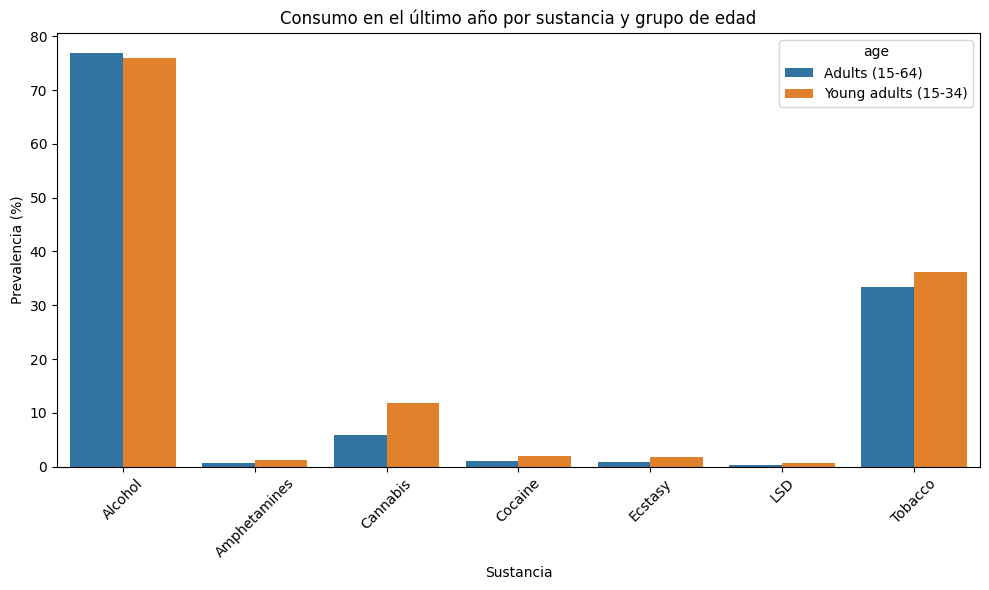

In [ ]:
#3 GRÁFICO BARPLOT
plt.figure(figsize=(10,6))
sns.barplot(
    data=age_stats,
    x="substance",
    y="prevalence_(%)",
    hue="age"
)
plt.title("Consumo en el último año por sustancia y grupo de edad")
plt.xlabel("Sustancia")
plt.ylabel("Prevalencia (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# DEFENSA
## “Para analizar la influencia de la edad, hemos comparado jóvenes adultos (15–34) frente a adultos (15–64), manteniendo constante el periodo de recuerdo ‘Last year’ y utilizando el año más reciente disponible para cada país.



## Al calcular la prevalencia media por sustancia y grupo de edad, observamos que en la mayoría de sustancias los jóvenes adultos presentan valores más altos de consumo que el grupo adulto.



## Esta diferencia no es uniforme: es especialmente marcada en sustancias como cannabis y éxtasis, mientras que en otras es menor.



## Por tanto, los resultados indican que la edad influye en el consumo, pero la magnitud de esta diferencia depende claramente del tipo de sustancia analizada.”